# Methodology (Data Analytics):
Dalam part ini, *Data Analytics* akan terbagi menjadi 2 part, yaitu *Descriptive Analytics* dan *Inferential Analytics*

In [ ]:
# Data
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.style.use('seaborn')

# Stats
from scipy.stats import pearsonr, spearmanr, shapiro, probplot

#addition
from operator import attrgetter

# Modeling
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project Purwadhika/data_outlist_clean.csv', parse_dates = ['order_purchase_timestamp'])
cust_df = pd.read_csv('/content/drive/MyDrive/Project Purwadhika/customer.csv')

In [ ]:
cust_df.head()

,customer_unique_id,recency,frequency,monetary,avg_spend,most_payment_type,avg_review_score,most_product_buy,first_transaction
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,141.90,credit_card,5.0,bed_bath_table,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,27.19,credit_card,4.0,health_beauty,2018-05
2,0000f46a3911fa3c0805444483337064,543,1,86.22,86.22,credit_card,3.0,stationery,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,43.62,credit_card,4.0,telephony,2017-10
4,0004aac84e0df4da2b147fca70cf8255,294,1,196.89,196.89,credit_card,5.0,telephony,2017-11


In [ ]:
df.head()

,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,product_photos_qty,payment_sequential,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english,month_order,weekday_order,month_year_order,date_order
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1.0,1.0,credit_card,146.87,4.0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,office_furniture,May,Tuesday,2017-05,16
1,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,1.0,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,1.0,1.0,credit_card,157.73,5.0,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,office_furniture,May,Saturday,2018-05,19
2,951670f92359f4fe4a63112aa7306eba,2018-03-13,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,1.0,1.0,credit_card,173.30,5.0,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,office_furniture,March,Tuesday,2018-03,13
3,997fd4b37386d10b57d4ac8cdec011a6,2018-07-08,1.0,8ed094bfe076c568f6bb10feada3f75d,199.98,115.77,1.0,1.0,credit_card,315.75,1.0,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,office_furniture,July,Sunday,2018-07,8
4,b63fff1ef8b6201df68bb611ee41129e,2017-04-02,1.0,aba86c093ccdbac75b09111d57e50004,129.60,16.61,1.0,1.0,boleto,146.21,4.0,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,office_furniture,April,Sunday,2017-04,2


## Descriptive Analysis Part 1:
Descriptive Analysis dilakukan untuk mengetahui keadaan perusahaan saat ini. Analysis ini dilakukan pada data transaksi *customer* untuk melihat transaksi *behavior* dari *customer*

In [ ]:
cust_df.describe()

,recency,frequency,monetary,avg_spend,avg_review_score
count,94087.000000,94087.000000,94087.000000,94087.000000,94087.000000
mean,243.803575,1.033671,213.601225,158.707160,4.089175
std,153.156983,0.208938,644.666063,218.506541,1.336863
min,1.000000,1.000000,9.590000,1.856818,1.000000
25%,120.000000,1.000000,64.000000,60.865000,4.000000
50%,224.000000,1.000000,113.050000,103.650000,5.000000
75%,353.000000,1.000000,203.300000,175.770000,5.000000
max,730.000000,15.000000,109312.640000,13664.080000,5.000000


In [ ]:
cust_df.describe(include='object')

,customer_unique_id,most_payment_type,most_product_buy,first_transaction
count,94087,94087,94087,94087
unique,94087,4,69,23
top,55ada0c8e02119e570b002a700dac03f,credit_card,bed_bath_table,2017-11
freq,1,72203,8761,7118


### Waterfall Plot:
*Waterfall plot* dapat digunakan untuk memvisualisasi dinamika dari *user* baru. *Waterfall plot* akan mengambil interval secara perbulan dari tahun 2016 bulan September, transaksi pertama dari perusahaan *Olist*

In [ ]:
# Data untuk Waterfall
waterfall = cust_df.groupby('first_transaction', as_index=False).agg({'customer_unique_id': 'count'})
waterfall['changes'] = waterfall['customer_unique_id'].diff()
waterfall.replace(np.nan, 0, inplace = True)
waterfall.rename(columns = {'first_transaction':'year-month', 'customer_unique_id':'new_customer'}, inplace = True)
waterfall.head()

,year-month,new_customer,changes
0,2016-09,2,0.0
1,2016-10,303,301.0
2,2016-12,1,-302.0
3,2017-01,744,743.0
4,2017-02,1656,912.0


In [ ]:
#1. Create layout
layout = go.Layout(
    title = 'Waterfall Plot for New User (2016 - 2018)',
    showlegend = False,
    yaxis = dict(title = 'Changes Number of New User'),
    xaxis = dict(title = 'Years-Month')
)

#2. Create the waterfall plot
fig = go.Figure(go.Waterfall(
    name = 'User Number',
    orientation = 'v',
    textposition = 'outside',
    measure = ['relative' for x in range(len(waterfall['new_customer']))] + ['total'],
    x = waterfall['year-month'].tolist(),
    y = waterfall['changes'].tolist(),
    text = [str(x) if x <= 0 else "+" + str(x) for x in waterfall['changes']],
    connector = {'line':{"color":'rgb(63,63,63)', "dash":"solid"}},
),
layout = layout)

fig.show()

> Keterangan:
- *User* pertama yang didapatkan dari *marketplace Olist* dimulai pada tahun 2016 bulan September, sebesar 3 *user*
- *User* *marketplace Olist* sampaii dengan tahun 2018 bulan September, sudah memiliki 94087 *user*. 
- Hampir setiap bulannya, *marketplace Olist* mendapatkan *user* tambahan, dan puncaknya pada tahun 2017 bulan November, bertambah sebanyak 2759 *user* dibandingkan bulan sebelumnya
- Pada beberapa bulan, penambahan *user* dari *marketplace olist* tidak sebanyak atau lebih sedikit dari bulan sebelumnya sehingga kami akan mengecek apakah penambahan *user* setiap bulannya ada korelasinya dengan jumlah transaksi *user* yang menggunakan *voucher*

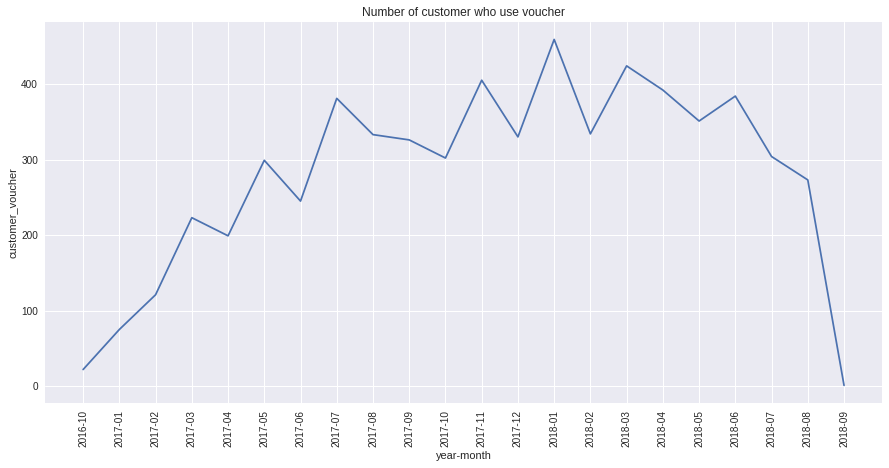

In [ ]:
df_line = df[df['payment_type'] == 'voucher'].groupby('month_year_order', as_index = False).agg({'customer_unique_id': 'count'})
df_line.rename(columns = {'month_year_order': 'year-month', 'customer_unique_id' : 'customer_voucher'}, inplace = True)

# Plot penggunaan voucher
plt.figure(figsize = (15, 7))
sns.lineplot(x = 'year-month', y = 'customer_voucher', data = df_line)
plt.title("Number of customer who use voucher")
plt.xticks(rotation = 90)
plt.show()

> Keterangan:
- Ketika trasaksi *user* yang menggunakan *voucher* berada di puncak, biasanya ada penambahan *user* baru. 
- Jumlah transaksi *user* yang menggunakan *voucher* paling puncak berada pada tahun 2018 bulan Maret, berada pada 459.
- Penambahan *user* pada periode tersebut ada sebanyak 1499 *user* dibanding bulan sebelumnya, kedua tertinggi setelah periode tahun 2017 bulan November.


### Kesimpulan dari Descriptive Analysis Part 1:
Berdasarkan point-point tersebut, kami memiliki *hypothesis* bahwa ada korelasi yang kuat antara penambahan *user* baru dengan transaksi *user* yang menggunakan *voucher* sehingga dapat dikatakan bahwa *user* baru akan bertambah apabila adanya *voucher*. <p>

## Inferential Analysis Part 1:
*Inferential Analysis* digunakan untuk membuktikan *hypothesis* yang sudah dibuat pada *Descriptive Analysis* sehingga kita dapat mengeneralisasi untuk populasi dari *customer* pada *marketplace olist*. <p>

Hypothesis yang ingin di cek:
- Ada korelasi yang kuat antara *user baru* dan jumlah transaksi *user* yang menggunakan voucher pada *marketplace Olist* dalam rentang waktu tahun 2016 bulan September sampai dengan tahun 2018 bulan September

### Normal Test:
Sebelum melakukan pengecekan *hypothesis*, ada lebih baiknya untuk mengetahui distribusi data dari jumlah *user* baru setiap bulan dan jumlah transaksi *user* yang menggunakan *voucher* agar kami dapat mengetahui metode mana yang harus digunakan. Untuk *significance level*, kami akan menggunakan 0.05. Alasan kami menggunakan *Significance level* 0.05 karena *significance level* tersebut merupakan hal yang umum digunakan, kecuali untuk *medical*. *Significance level* 0.05 artinya menunjukkan bahwa kemungkinan tingkat kesalahannya akan sebesar 5%<p>

- h0: data tersdistribusi normal
- ha: data tidak terdistribusi normal

In [ ]:
voucher = pd.merge(waterfall, df_line, how = 'left', on = 'year-month')
voucher.replace(np.nan, 0, inplace = True)

# Normality Test
new_stats, new_pvalue = shapiro(voucher['new_customer'])
trans_stats, trans_pvalue = shapiro(voucher['customer_voucher'])

if new_pvalue < 0.05:
  print(f'P-val dari distibusi customer baru: {round(new_pvalue, 2)}, tolak h0 sehingga data tidak terdistribusi normal')
else:
  print(f'P-val dari distibusi customer baru: {round(new_pvalue, 2)}, terima h0 sehingga data terdistribusi normal')

if trans_pvalue < 0.05:
  print(f'P-val dari distibusi transaksi customer yang menggunakan voucher: {round(trans_pvalue, 2)}, tolak h0 sehingga data tidak terdistribusi normal')
else:
  print(f'P-val dari distibusi transaksi customer yang menggunakan voucher: {round(trans_pvalue, 2)}, terima h0 sehingga data terdistribusi normal')

P-val dari distibusi customer baru: 0.04, tolak h0 sehingga data tidak terdistribusi normal
P-val dari distibusi transaksi customer yang menggunakan voucher: 0.02, tolak h0 sehingga data tidak terdistribusi normal


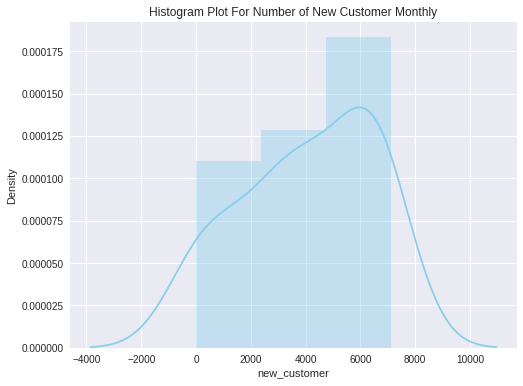

In [ ]:
plt.figure(figsize = (8,6))
sns.distplot(voucher['new_customer'], color="skyblue")
plt.title('Histogram Plot For Number of New Customer Monthly')
plt.show()

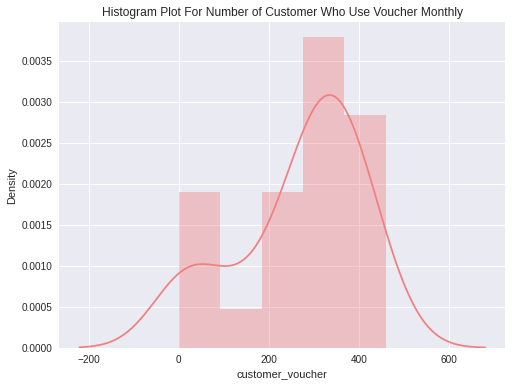

In [ ]:
plt.figure(figsize = (8,6))
sns.distplot(voucher['customer_voucher'], color = 'lightcoral')
plt.title('Histogram Plot For Number of Customer Who Use Voucher Monthly')
plt.show()

> Keterangan: <p> 
Pvalue dari variable "new_customer" dan "customer_voucher" kurang dari 0.05, artinya kami tidak memiliki bukti yang cukup kuat untuk menerima h0 sehingga kedua variable tersebut dapat dikatakan tidak terdistribusi normal. Karena kedua variable tersebut tidak terdistribusi normal, uji korelasi yang dapat digunakan adalah *spearman*.

### Correlation Test:
Uji korelasi dilakukan untuk mengetahui apakah adanya korelasi antara jumlah pengguna baru setiap bulannya dengan transaksi *user* yang menggunakan *voucher* setiap bulannya. Berdasarkan data distribusi di atas, uji korelasi yang tepat digunakan adalah *Spearman Method*. *Signifiance level* yang digunakan untuk test ini juga sama seperti sebelumnya, yaitu 0.05.

In [ ]:
# Correlation Test
spearmanr(voucher['customer_voucher'], voucher['new_customer'])

SpearmanrResult(correlation=0.9038794444459544, pvalue=3.397791535907595e-09)

In [ ]:
new_cust = cust_df[(cust_df['frequency'] == 1) & (cust_df['most_payment_type'] == 'voucher')]['customer_unique_id'].count()

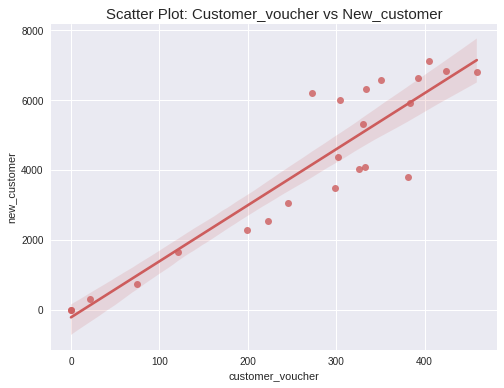

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x = 'customer_voucher', y = 'new_customer', data = voucher, color = 'indianred')
plt.title('Scatter Plot: Customer_voucher vs New_customer', size = 15)
plt.show()

## Kesimpulan dari Inferential Analysis Part 1: 
Dari hasil pengujian diatas, h0 untuk *correlation test* dapat diterima yang artinya ada hubungan yang kuat antara pertambahan *user* baru tiap bulannya dengan transaksi *user* yang menggunakan *voucher* setiap bulannya. Korelasi antara kedua variable tersebut juga tergolong korelasi yang kuat, sebesar 0.90. Dengan *correlation test* di atas dapat dikatakan bahwa penggunaan *voucher* untuk mendapatkan *user* baru tergolong berhasil. 

## Descriptive Analysis Part 2:
Pada bagian ini, kami ingin melihat *retention user* terhadap *marketplace olist*

### Cohort Analysis: 
Analysis ini berguna untuk melihat *engagement user* dari *marketplace Olist* dari waktu ke waktu.

In [ ]:
# Data Preprocessing
df['cohort_month'] = df.groupby("customer_unique_id")['order_purchase_timestamp'].transform('min').dt.to_period('M')
df['current_order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

df_cohort = df.groupby(['cohort_month', 'current_order_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)
df_cohort['period_number'] = (df_cohort['current_order_month'] - df_cohort['cohort_month']).apply(attrgetter('n'))
df_cohort.head()

,cohort_month,current_order_month,n_customers,period_number
0,2016-09,2016-09,2,0
1,2016-10,2016-10,303,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


In [ ]:
# Cohort Retention
cohort_retention_pivot = df_cohort.pivot_table(index = 'cohort_month',
                                               columns = 'period_number',
                                               values = 'n_customers')

# Transform to percentage:
cohort_size = cohort_retention_pivot.iloc[:,0]
retention_in_percentage = cohort_retention_pivot.divide(cohort_size, axis = 0)

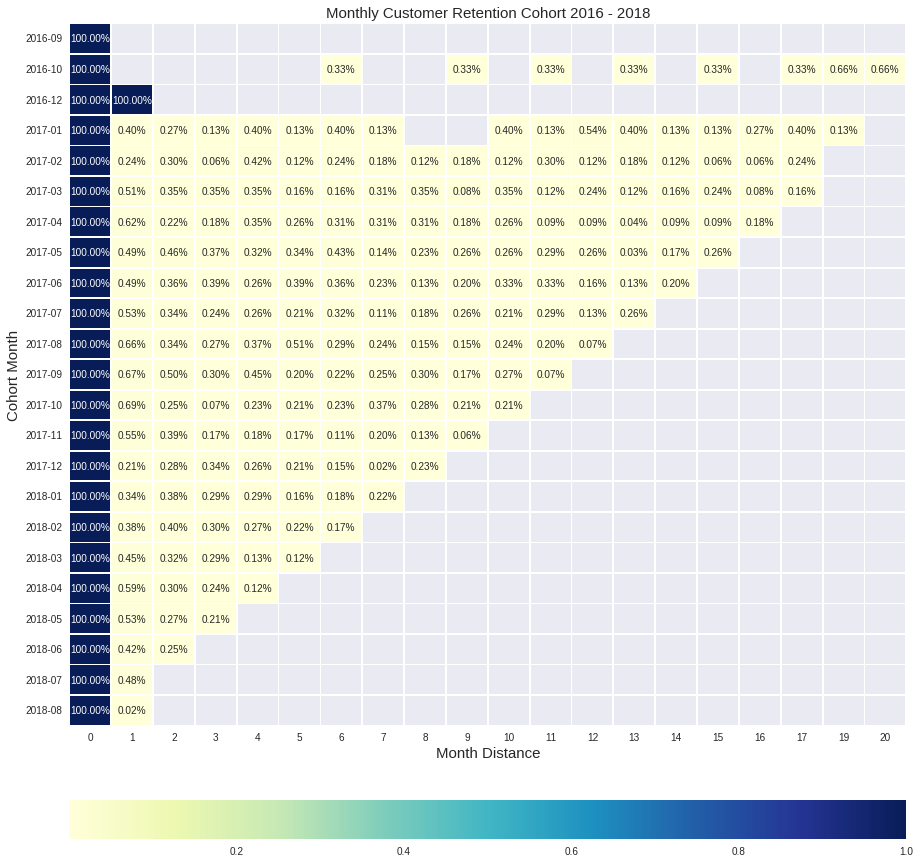

In [ ]:
# Cohort Visualization
## Setup
grid_kws = {'height_ratios': (.9,.05), 'hspace':.2}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize = (15, 15))

# Heatmap
ax = sns.heatmap(retention_in_percentage,
                 ax = ax,
                 cbar_ax = cbar_ax,
                 annot = True,
                 fmt = '.2%',
                 linewidths = .8,
                 cbar_kws = {'orientation': 'horizontal'},
                 cmap = 'YlGnBu'
                 )

# info
ax.set_title('Monthly Customer Retention Cohort 2016 - 2018', fontsize = 15)
ax.set_ylabel('Cohort Month', fontsize = 15)
ax.set_xlabel('Month Distance', fontsize = 15)
plt.show()

In [ ]:
print("Persentase User yang hanya melakukan transaksi 1 kali: " ,round(len(cust_df[cust_df['frequency'] == 1])/len(cust_df), 2) * 100)

Persentase User yang hanya melakukan transaksi 1 kali:  97.0


> Keterangan :
- Pada *cohort analysis*, kami mendapatkan bahwa *retention rate* dari seorang *customer* selama rentang periode tahun 2016 - 2018 terbilang sangat rendah, rata-rata dibawah 1%, artinya *user* dari *Olist* sangat jarang yang menggunakan *marketplace Olist* kembali.
- Hal tersebut diperkuat dari proses *EDA* sebelumnya, dimana 97% *user* *frequency*-nya hanya 1 kali. 

In [ ]:
def statify(x):
  if x >= 4:
    return "Yes"
  elif x == 3:
    return "Neutral"
  else:
    return "No"

cust_df['satisfaction'] = cust_df['avg_review_score'].apply(statify)

# Simulation loss customer
loss = len(cust_df[(cust_df['frequency'] == 1) & (cust_df['satisfaction'] == 'No')])
print("Kemungkinan Kehilangan user: ", loss)
print("Kemungkinan Kehilangan user (%): ", round(loss/len(cust_df) * 100, 2))

Kemungkinan Kehilangan user:  13305
Kemungkinan Kehilangan user (%):  14.14


# Analysis Result:
- Dalam rentang 2 tahun (2016 - 2018), *marketplace Olist* berhasil mengakuisisi *user* baru sebanyak 94087 *user* baru. 
- Penambahan *user* baru paling banyak berada pada periode 2017 bulan November, sebesar 2977 *user*. 
- Dengan tingkat kesalahan (*significance level*) sebesar 0.05 atau 5%, penambahan *user* baru memiliki korelasi dengan yang kuat dengan jumlah transaksi *user* yang menggunakan *voucher*. Hal tersebut menunjukkan bahwa pemberian *voucher* dapat meningkatkan *user* baru.
- Penambahan *user* baru yang tinggi tidak disertai dengan *retention rate* dari *user* pada *marketplace Olist*. *Retention Rate user* rata-rata berada dibawah 1% dan hal ini merupakan masalah yang fatal karena *Olist* selalu membutuhkan *user* baru untuk mendapatkan *revenue* yang besar. 
- Solust yang dapat ditawarkan untuk meningkatkan *retention user* yang sudah ada adalah dengan memberikan *treatment* tertentu, seperti *voucher*, *loyalty points*, dan lainnya.  - Untuk mengetahui *treatment* yang sesuai dengan *user*, hal pertama yang harus dilakukan *marketplace Olist* adalah mengetahui ada berapa kelompok yang memiliki *behavior* transaksi yang sama dan untuk mengetahuinya *Olist* dapat membuat *customer segmentation* berdasarkan *behavior* dari *user*